Date: 2024-12-11

Latest change when and what:

Notes:

# Baseline models: Bag og Words and tf-idf

Trying different baseline models and comparing their outcomes. Please note - all the models were first run using the training and the validation datasets. When the parameters of the models had been chosen, we then finally tested on the test dataset, too. So, the test dataset was only used once.

In [3]:
# importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score, classification_report, roc_auc_score, roc_curve, average_precision_score, make_scorer, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split

import pickle as pkl
from sklearn.datasets import make_classification
from wordcloud import WordCloud

In [4]:
# loading train, test and validation datasets - lowercase!
train_data = pd.read_csv("../2_preprocessing/train_lowercase.csv")
test_data = pd.read_csv("../2_preprocessing/test_lowercase.csv")
val_data = pd.read_csv('../2_preprocessing/validation_lowercase.csv')

In [161]:
# checking average number of characters in scripts - just to get info
average_characters = train_data['script'].apply(len).mean()
average_characters = round(average_characters,0)

print(f"Average number of characters: {average_characters}")

Average number of characters: 124366.0


## Bag of Words (BoW)

.fit_transform uses the input to create the frequency matrix of words.
.transform counts the words in the input using the frequency matrix already created with the training data
so if a word is not present in the frequency matrix created with the training data, it is lost

In [12]:
# creating frequency matrix using the training data and transforming the validation and the test dataset
# train data 
texts_train = train_data["script"].to_list()
y_train = train_data.passed_bechdel.to_list()

# create frequency matrix of words
vectorizer = CountVectorizer()
features_train = vectorizer.fit_transform(texts_train) # only for training!

# validation data 
texts_val = val_data["script"].to_list()
y_val = val_data.passed_bechdel.to_list()

# plot the words in the validation dataset in the matrix made on the training data 
features_val = vectorizer.transform(texts_val) # notice - only transform, not fitting

# test data 
texts_test = test_data["script"].to_list()
y_test = test_data.passed_bechdel.to_list()

# plot the words in the test dataset in the matrix made on the training data 
features_test = vectorizer.transform(texts_test) 

In [21]:
# sanity check
print(features_train.shape)
print(len(vectorizer.vocabulary_))
vectorizer.vocabulary_

(1418, 339126)
339126


{'alice': 24707,
 'by': 57022,
 'linda': 179313,
 'woolverton': 331083,
 'based': 41067,
 'on': 215199,
 'alices': 24717,
 'adventures': 21218,
 'in': 155352,
 'wonderland': 330728,
 'through': 299850,
 'the': 296163,
 'looking': 181877,
 'glass': 129786,
 'lewis': 177850,
 'carroll': 60852,
 '9908': 16306,
 'white': 327154,
 'shooting': 267457,
 'script': 260843,
 '102808': 1088,
 'blue': 48766,
 'revised': 249266,
 'pages': 221513,
 'fade': 111324,
 'ext': 109990,
 'london': 181445,
 '1855': 5003,
 'night': 207163,
 'warm': 322703,
 'light': 178648,
 'shines': 266736,
 'from': 122918,
 'study': 285868,
 'of': 212872,
 'gracious': 132809,
 'kingsley': 170421,
 'home': 147723,
 'man': 186254,
 'silhouetted': 269586,
 'window': 328945,
 'speaks': 277925,
 'with': 329731,
 'ardor': 31950,
 'int': 158081,
 'cont': 74527,
 'charles': 64479,
 'has': 140640,
 'just': 167187,
 'described': 87760,
 'his': 146397,
 'new': 206267,
 'venture': 317957,
 'to': 302274,
 'friends': 122609,
 'includin

### BoW logistic regression
The logistic regression was run using the lbfgs, the linear and the saga solver and different penalty terms were tested. Different numbers of max iterations and C (inverse regularization parameter) were tested, too. 
The lbfgs solver did not converge, so it was not included in the param grid search below. 

The param grid search was a bit flawed, in that it would suggest a model which did not converge.
The final model included: 

In [ ]:
# Example parameter grid for Logistic Regression
param_grid = {
    'C': [0.0001, 0.001, 0.01],  # Regularization strength (inverse, smaller value = more regularization)
    'penalty': ['l1', 'l2'],               # Type of regularization
    'solver': ['liblinear', 'saga'],
    'max_iter': [500]       
}

# Define the logistic regression model
log_reg = LogisticRegression(random_state=42, max_iter = 500)

# Set up GridSearchCV
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='f1', n_jobs=-1)

# Fit the model to the training data
grid_search.fit(features_train, y_train)

# Output the best hyperparameters found by GridSearchCV
print("Best parameters:", grid_search.best_params_)
print("Best F1 score:", grid_search.best_score_)

# You can also access the best estimator (model) directly
best_model = grid_search.best_estimator_

# evaluate on validation dataset
val_score = best_model.score(features_val, y_val)
print("Validation dataset accuracy with best model:", val_score)


{'C': 0.01, 'penalty': 'l1', 'solver': 'saga'}
'C': 0.01, 'penalty': 'l1', 'solver': 'saga'}

previous: C=1, l2 (default), liblinear, max_iter = 500)

l1, saga, C = 0.001, and max iter = 

In [ ]:
#initializing logistic regression model
clf_log_reg = LogisticRegression(
    penalty = 'elasticnet', # used elasticnet to use both the L1 and L2 penalty terms
    C = 0.001, # added more regularization
    #random_state=42 - doesn't make a difference
    solver = 'saga',
    max_iter = 10000, #upped the number of iterations from 500 to 1000 to make the model converge
    l1_ratio = 0.5).fit(features_train, y_train) # the ratio of the penalty terms is 50/50

In [6]:
# save / reload model
#pkl.dump(clf_log_reg, file=open(f'/work/classes/NLP_exam/3_model_selection/output/models/BoW_log_reg_elasticnet_saga.pkl', 'wb')) # save the model
clf_log_reg = pkl.load(open('/work/classes/NLP_exam/3_model_selection/output/models/BoW_log_reg_elasticnet_saga.pkl','rb'))

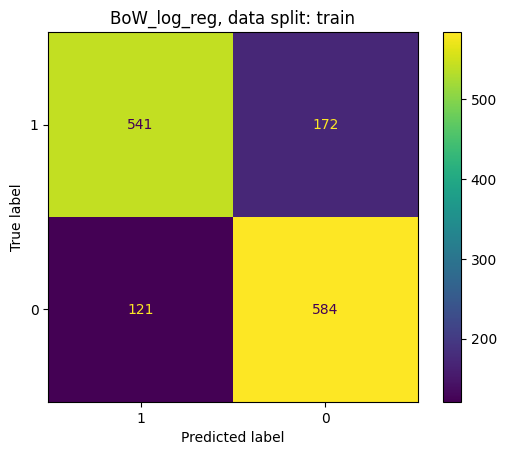

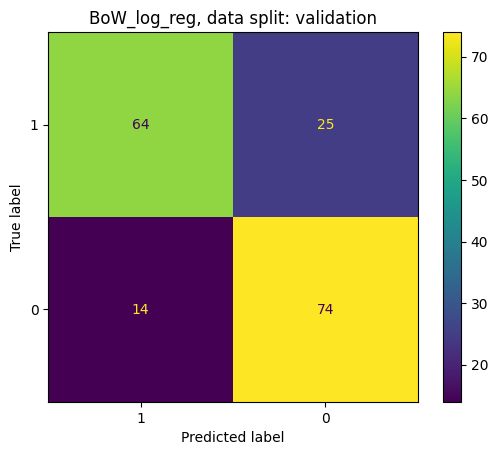

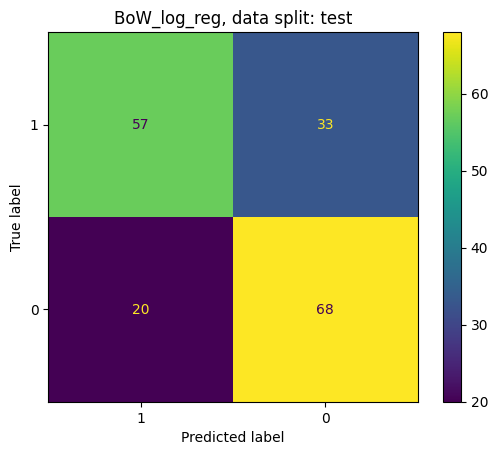

,model,split,mean_acc_score,f1_score,roc_auc,true_positives,true_negatives,false_positives,false_negatives,cr_label0_precision,cr_label0_recall,cr_label0_f1_score,cr_label0_support,cr_label1_precision,cr_label1_recall,cr_label1_f1_score,cr_label1_support
0,BoW_log_reg,train,0.7934,0.7869,0.866432,541,584,121,172,0.772487,0.828369,0.799452,705.0,0.817221,0.758766,0.786909,713.0
1,BoW_log_reg,validation,0.7797,0.7665,0.867339,64,74,14,25,0.747475,0.840909,0.791444,88.0,0.820513,0.719101,0.766467,89.0
2,BoW_log_reg,test,0.7022,0.6826,0.746338,57,68,20,33,0.673267,0.772727,0.719577,88.0,0.740260,0.633333,0.682635,90.0


In [13]:
# evaluate model on validation dataset and save performance metrics
performance_df = pd.DataFrame()
model = clf_log_reg
model_name = 'BoW_log_reg'

for x, y, nsplit in zip([features_train, features_val, features_test],
                        [y_train, y_val, y_test],
                        ['train', 'validation', 'test']):
    mean_accuracy_score = model.score(x, y) 
    preds = model.predict(x)
    f1 = f1_score(y, preds)
    class_report = classification_report(y, preds, output_dict = True)
    roc_auc = roc_auc_score(np.array(y), model.predict_proba(x)[:,1]) # takes the probabiltiy of label = 1 (=passing the bechdel-test)
  
    # create and plot confusion matrix
    disp = ConfusionMatrixDisplay.from_predictions(y, preds, labels = [1,0])
    disp.ax_.set_title(f"{model_name}, data split: {nsplit}")
    plt.savefig(f'./output/figures/{model_name}_{nsplit}_confusion_matrix.jpeg')
    plt.show()

    # Create a dictionary with metrics for the current split
    metrics = {
        'model': model_name,
        'split': nsplit,
        'mean_acc_score': round(mean_accuracy_score, 4),
        'f1_score': round(f1, 4),
        'roc_auc': roc_auc,
        # add confusion matrix values
        'true_positives': disp.confusion_matrix[0][0],
        'true_negatives': disp.confusion_matrix[1][1],
        'false_positives': disp.confusion_matrix[1][0],
        'false_negatives': disp.confusion_matrix[0][1],
        # per label precision, recall, f1_score and support
        'cr_label0_precision': class_report['0']['precision'],
        'cr_label0_recall': class_report['0']['recall'],
        'cr_label0_f1_score': class_report['0']['f1-score'],
        'cr_label0_support': class_report['0']['support'],
        'cr_label1_precision': class_report['1']['precision'],
        'cr_label1_recall': class_report['1']['recall'],
        'cr_label1_f1_score': class_report['1']['f1-score'],
        'cr_label1_support': class_report['1']['support']
    }
    
    # Convert the dictionary to a DataFrame and concatenate it with the main DataFrame
    performance_df = pd.concat([performance_df, pd.DataFrame([metrics])], ignore_index=True)

# Display the performance metrics
performance_df


### Check-out words which are not in the BoW model (not in training data)

In [ ]:
# create frequency matrix of words
vectorizer = CountVectorizer()
features_train = vectorizer.fit_transform(texts_train) 
vocab_train = set(vectorizer.vocabulary_.keys())

# CREATE FOR VAL
vectorizer = CountVectorizer()
features_train = vectorizer.fit_transform(texts_val) 
vocab_val = set(vectorizer.vocabulary_.keys())

# CREATE FOR TEST
vectorizer = CountVectorizer()
features_train = vectorizer.fit_transform(texts_test) 
vocab_test = set(vectorizer.vocabulary_.keys())

In [ ]:
# percentage of tokens in validation not in training
print("percentage of tokens in validation data not present in training: ")
print(round(len(vocab_val - vocab_train) / len(vocab_val),2))

percentage of words in validation data not present in training: 
0.29


In [58]:
# percentage of tokens in test not in training
print("percentage of tokens in test data not present in training: ")
print(round(len(vocab_test - vocab_train) / len(vocab_test),2))

percentage of tokens in test data not present in training: 
0.31


In [ ]:
# double-checking results

counter = 0
missing_words = []

# Check each word in vocab_val
for word in vocab_val:
    if word not in vocab_train:
        counter += 1
        missing_words.append(word)

# Output the results
print(f"Words from vocab_val not in vocab_train: {missing_words}")
print(f"Number of words not in vocab_train: {counter}")

Words from vocab_val not in vocab_train: ['shotnolan', 'propsdecorations', 'sovieteast', 'undeterminable', 'expolice', 'gillikin', 'farges', 'ungainliness', 'ceasars', 'wked', 'headsetsa', 'plaform', 'desertday', 'thentheyll', '000758', 'barnhardt', 'staysput', 'polychrome', 'appfar', 'croatians', 'nopejust', 'yud', 'jirak', 'mactress', '19741989', 'yahoooo', 'queensryche', 'rminator', 'moocow', 'psychanalysis', 'gardeningwalking', 'crotchlevel', 'nunting', 'outlays', 'waveswingers', 'agked', 'gaiz2s97', 'aunéred', 'smasheson', 'coonan', 'tightwired', 'drepesactually', 'fingerfuls', 'blackhats', 'minuteive', 'nfknfkpl', 'supercuts', 'grinwhat', 'dawnkissed', 'abbandando', 'baa46', 'asdasd', 'dawo', 'breathebreathethats', 'silvernosed', 'eoy7q', 'heavilyshe', 'bellarts', '3570', 'downioading', 'leoriard', 'ftailing', 'breakrast', '___ee', 'bosslook', 'hulkingcrashing', 'abaze', 'blueflamed', 'velvetdv', 'sokolovs', 'meanhere', 'feetthats', 'broadway1992', 'diracs', 'litanyof', 'tessio',

In [59]:
# double-checking results

counter = 0
missing_words = []

# Check each word in vocab_val
for word in vocab_test:
    if word not in vocab_train:
        counter += 1
        missing_words.append(word)

# Output the results
print(f"Words from vocab_test not in vocab_train: {missing_words}")
print(f"Number of words not in vocab_train: {counter}")

Words from vocab_test not in vocab_train: ['painrand', 'that3', 'svinmint', 'johnjules', 'loganberries', 'sensimilla', 'onbidly', 'wihite', 'standi', 'etony', 'urrrrrrrrrrggggghhh', 'savat', 'hokes', 'wichers', 'nougats', 'pipedottels', 'easts', 'asleeeeeep', 'mugu', 'fühlen', 'twowomen', 'exponses', 'hyperacute', '161d162', 'officercautious', 'phenodihydrochloride', 'smollett', 'chaurasia', 'elizondo', 'waterkole', '73094113', 'lovelesss', 'gneried', 'figuresconferring', 'exfighters', 'daggetts', 'belladonnas', 'cassians', 'cnant', 'engrained', 'etoy', 'wolfmandespite', 'lajiang', 'overmining', 'macgloandesmond', 'bloodberry', 'astigmatic', 'ionty', 'summera', 'merc1', 'offictalsse', 'eelay', 'sjolie', 'arjun', 'lookingwho', 'keyholeshaped', 'shnapp', 'cemee', 'taqueria', 'freshlymowed', 'weapnns', 'switeks', '12min', 'pitabhash', 'mmmeeeeeeee', 'naturellé', 'anogre', 'extrajaunty', 'toksovo', 'serpe', 'ccb', 'ihgbhink', 'indrawmn', 'kazickis', 'wynneand', 'cpohee', 'ofirae', 'safethe

### Feature importance

In [ ]:
features_train.get_feature_names

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 5106997 stored elements and shape (1418, 339126)>

In [8]:
# examining coefficients 

clf_log_reg.coef_
clf_log_reg.n_features_in_.features_names_in
#clf_log_reg.feature_n

AttributeError: 'int' object has no attribute 'features_names_in'

### BoW random forest

To select the hyperparameters of the model, I performed a randomized search, which randomly puts together x number of combinations of the different hyperparameter values (here 10 combinations), performs five-fold cross validation and finally estimates the best parameters given the scoring metric which I've given the model (here, f1). 

In [ ]:
## randomized search
# Define the parameter grid
param_grid = {
    'n_estimators': [10, 50, 100], # number of trees - deafult is 10
    'max_depth': [5, 10, 20],      # max number of splits/leaves (leaf = node without children) - stopping criteria # default is none
    'min_samples_split': [2, 5, 10], # min. number of samples required to split an internal node, default is 2
    'max_features': [0.3, 0.6, 0.9], # proportion of features to max. use in a tree (subset proportion) - default is 1.0 (= all features)
    'ccp_alpha': [0.01, 0.1, 1.0] # minimal-cost complexity pruning - to overvoid overfitting, default 0.0 
}

# Initialize the Random Forest Classifier
clf_forest = RandomForestClassifier(random_state=42)

clf_forest_rs = RandomizedSearchCV(estimator=clf_forest, 
                            param_distributions=param_grid,
                            scoring='f1',
                            n_iter=10, 
                            cv=5,
                            verbose = 2,
                            n_jobs = -1)


In [13]:
randomized_search = clf_forest_rs.fit(features_train, y_train)

# get best parameters of the randomized search 
randomized_search.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ccp_alpha=1.0, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=10; total time=  14.8s
[CV] END ccp_alpha=1.0, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=10; total time=  14.9s
[CV] END ccp_alpha=1.0, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=10; total time=  15.3s
[CV] END ccp_alpha=1.0, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=10; total time=  16.2s
[CV] END ccp_alpha=1.0, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=10; total time=  16.3s
[CV] END ccp_alpha=0.01, max_depth=5, max_features=0.9, min_samples_split=2, n_estimators=50; total time= 1.3min
[CV] END ccp_alpha=0.01, max_depth=5, max_features=0.9, min_samples_split=2, n_estimators=50; total time= 1.3min
[CV] END ccp_alpha=0.01, max_depth=5, max_features=0.9, min_samples_split=2, n_estimators=50; total time= 1.3min
[CV] END ccp_alpha=0.01, max_depth=

{'n_estimators': 100,
 'min_samples_split': 2,
 'max_features': 0.3,
 'max_depth': 20,
 'ccp_alpha': 0.01}

In [ ]:
# initializing random forest with the hyperparameters from the randomized search 
clf_forest = RandomForestClassifier(
    n_estimators = 100,
    min_samples_split = 2, 
    max_features = 0.3,
    max_depth = 20, 
    ccp_alpha = 0.01,
    random_state=42).fit(features_train, y_train)

In [12]:
model = clf_forest

for x, y, nsplit in zip([features_train, features_val, features_test],
                        [y_train, y_val, y_test],
                        ['train', 'val', 'test']):
    mean_accuracy_score = model.score(x, y) 
    preds = model.predict(x)
    f1 = f1_score(y, preds)
    class_report = classification_report(y, preds, output_dict = True)
    roc_auc = roc_auc_score(np.array(y), model.predict_proba(x)[:,1]) # takes the probabiltiy of label = 1 (passing the bechdel-test)
    
    # Create a dictionary with metrics for the current split
    metrics = {
        'model': 'BoW_rf',
        'split': nsplit,
        'mean_acc_score': round(mean_accuracy_score, 4),
        'f1_score': round(f1, 4),
        'cr_label0_precision': class_report['0']['precision'],
        'cr_label0_recall': class_report['0']['recall'],
        'cr_label0_f1_score': class_report['0']['f1-score'],
        'cr_label0_support': class_report['0']['support'],
        'cr_label1_precision': class_report['1']['precision'],
        'cr_label1_recall': class_report['1']['recall'],
        'cr_label1_f1_score': class_report['1']['f1-score'],
        'cr_label1_support': class_report['1']['support'],
        'roc_auc': roc_auc#,
        #'roc_curve': roc_curve_calc
    }
    
    # Convert the dictionary to a DataFrame and concatenate it with the main DataFrame
    performance_df = pd.concat([performance_df, pd.DataFrame([metrics])], ignore_index=True)

# Display the performance metrics
performance_df

,model,split,mean_acc_score,f1_score,cr_label0_precision,cr_label0_recall,cr_label0_f1_score,cr_label0_support,cr_label1_precision,cr_label1_recall,cr_label1_f1_score,cr_label1_support,roc_auc
0,BoW_log_reg,train,0.7934,0.7869,0.772487,0.828369,0.799452,705.0,0.817221,0.758766,0.786909,713.0,0.866432
1,BoW_log_reg,val,0.7797,0.7665,0.747475,0.840909,0.791444,88.0,0.820513,0.719101,0.766467,89.0,0.867339
2,BoW_log_reg,test,0.7022,0.6826,0.673267,0.772727,0.719577,88.0,0.740260,0.633333,0.682635,90.0,0.746338
3,BoW_rf,train,0.7786,0.7711,0.757576,0.815603,0.785519,705.0,0.802731,0.741935,0.771137,713.0,0.866319
4,BoW_rf,val,0.7627,0.7439,0.725490,0.840909,0.778947,88.0,0.813333,0.685393,0.743902,89.0,0.850613
5,BoW_rf,test,0.6798,0.6503,0.647619,0.772727,0.704663,88.0,0.726027,0.588889,0.650307,90.0,0.739899


In [ ]:
# save / reload model
#pkl.dump(clf_forest, file=open(f'/work/classes/NLP_exam/3_model_selection/output/models/BoW_random_forest.pkl', 'wb')) # save the model
#clf_forest = pkl.load(open('/work/classes/NLP_exam/3_model_selection/output/models/BoW_random_forest.pkl','rb'))

### BoW support vector classifier (SVC)

Here, I also perform a search for the best parameters, but this time I perform a gridsearch and not a randomized search. The difference is that the gridsearch performs an exhaustive search, that is, all possible combinations of hyperparameters are tested.

In [ ]:
# Define parameter grid for GridSearchCV
param_grid = {'C': [0.1, 0.01, 1], 'kernel': ['linear', 'rbf']}

# Perform grid search
grid_search = GridSearchCV(SVC(random_state=42, probability=True), param_grid, cv=5, n_jobs=-1)
grid_search.fit(features_train, y_train)

# Best parameters from grid search
print("Best Parameters:", grid_search.best_params_)
clf_svm = grid_search.best_estimator_

Best Parameters: {'C': 1, 'kernel': 'rbf'}


In [23]:
# support vector maching # max_iter=500
clf_svc = SVC(C=1, kernel = 'rbf', probability=True, random_state = 42).fit(features_train, y_train)
# C = 1 and kernel = 'rbf' is the default hyperparameters of the SVC

In [14]:
model = clf_svc
model_name = 'BoW_svc'

for x, y, nsplit in zip([features_train, features_val, features_test], 
                        [y_train, y_val, y_test],
                        ['train', 'val', 'test']):
    mean_accuracy_score = model.score(x, y) 
    preds = model.predict(x)
    f1 = f1_score(y, preds)
    class_report = classification_report(y, preds, output_dict = True)

    # Get predicted probabilities for the positive class (class 1)
    y_pred_proba = model.predict_proba(x)[:, 1]  # Probabilities for class 1

    # Compute the ROC AUC score
    roc_auc = roc_auc_score(np.array(y), y_pred_proba)

    #roc_auc = roc_auc_score(np.array(y), clf_svm.predict_proba(x)[:,1]) # takes the probabiltiy of label = 1 (passing the bechdel-test)
   # roc_curve_calc = roc_curve(np.array(y), clf_log_reg.predict_proba(x)[:,1])#, pos_label = 1)

    # Create a dictionary with metrics for the current split
    metrics = {
        'model': model_name,
        'split': nsplit,
        'mean_acc_score': round(mean_accuracy_score, 4),
        'f1_score': round(f1, 4),
        'cr_label0_precision': class_report['0']['precision'],
        'cr_label0_recall': class_report['0']['recall'],
        'cr_label0_f1_score': class_report['0']['f1-score'],
        'cr_label0_support': class_report['0']['support'],
        'cr_label1_precision': class_report['1']['precision'],
        'cr_label1_recall': class_report['1']['recall'],
        'cr_label1_f1_score': class_report['1']['f1-score'],
        'cr_label1_support': class_report['1']['support'],
        'roc_auc': roc_auc#,
        #'roc_curve': roc_curve_calc
    }
    
    # Convert the dictionary to a DataFrame and concatenate it with the main DataFrame
    performance_df = pd.concat([performance_df, pd.DataFrame([metrics])], ignore_index=True)

# Display the performance metrics
performance_df

,model,split,mean_acc_score,f1_score,cr_label0_precision,cr_label0_recall,cr_label0_f1_score,cr_label0_support,cr_label1_precision,cr_label1_recall,cr_label1_f1_score,cr_label1_support,roc_auc
0,BoW_log_reg,train,0.7934,0.7869,0.772487,0.828369,0.799452,705.0,0.817221,0.758766,0.786909,713.0,0.866432
1,BoW_log_reg,val,0.7797,0.7665,0.747475,0.840909,0.791444,88.0,0.820513,0.719101,0.766467,89.0,0.867339
2,BoW_log_reg,test,0.7022,0.6826,0.673267,0.772727,0.719577,88.0,0.740260,0.633333,0.682635,90.0,0.746338
3,BoW_rf,train,0.7786,0.7711,0.757576,0.815603,0.785519,705.0,0.802731,0.741935,0.771137,713.0,0.866319
4,BoW_rf,val,0.7627,0.7439,0.725490,0.840909,0.778947,88.0,0.813333,0.685393,0.743902,89.0,0.850613
5,BoW_rf,test,0.6798,0.6503,0.647619,0.772727,0.704663,88.0,0.726027,0.588889,0.650307,90.0,0.739899
6,BoW_svc,train,0.8096,0.7861,0.750288,0.924823,0.828463,705.0,0.903461,0.695652,0.786054,713.0,0.919259
7,BoW_svc,val,0.7571,0.7152,0.695652,0.909091,0.788177,88.0,0.870968,0.606742,0.715232,89.0,0.847612
8,BoW_svc,test,0.7135,0.6623,0.658120,0.875000,0.751220,88.0,0.819672,0.555556,0.662252,90.0,0.763510


In [ ]:
# save / reload model
#pkl.dump(clf_svc, file=open(f'/work/classes/NLP_exam/3_model_selection/output/models/BoW_svc.pkl', 'wb')) # save the model
#clf_svc = pkl.load(open('/work/classes/NLP_exam/3_model_selection/output/models/BoW_svc.pkl','rb'))

In [ ]:
# save model performances
#performance_df.to_csv('/work/classes/NLP_exam/3_model_selection/output/performances_df.csv', index = False)
# reload if stopping mid-way
#performance_df = pd.read_csv('/work/classes/NLP_exam/3_model_selection/output/performances_df.csv')

## Plotting BoW most frequent words

In [ ]:
# plot distinct words in each label based on frequencies 

# fix variable names
X = features_train.copy()
labels = train_data['passed_bechdel']

# Get the vocabulary mapping (word to column index)
vocabulary = vectorizer.vocabulary_
words = np.array(list(vocabulary.keys()))
word_indices = np.array(list(vocabulary.values()))

# Separate the word frequencies by label
X_label_0 = X[labels == 0].toarray().sum(axis=0)  # Word frequencies for label 0
X_label_1 = X[labels == 1].toarray().sum(axis=0)  # Word frequencies for label 1

# Calculate the difference in frequencies between label 1 and label 0
frequency_diff = X_label_1 - X_label_0

# Apply threshold filtering: Keep words with |frequency_diff| >= 5
threshold = 5
valid_indices = np.where(np.abs(frequency_diff) >= threshold)[0]
filtered_frequency_diff = frequency_diff[valid_indices]
filtered_words = words[word_indices.argsort()][valid_indices]

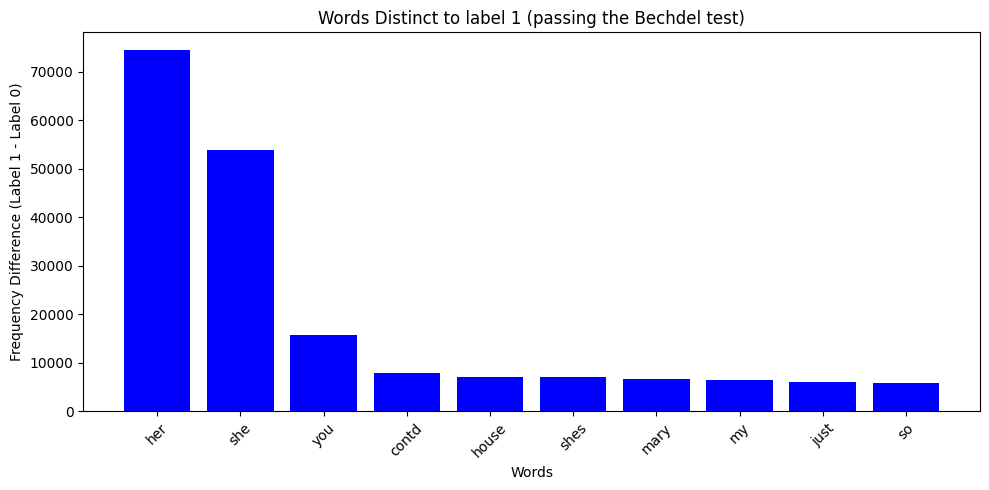

In [ ]:
# Find the top 10 words distinct to label 1
top_indices_distinct_label_1 = np.argsort(filtered_frequency_diff)[-10:][::-1]  # Largest positive differences
distinct_words_label_1 = filtered_words[top_indices_distinct_label_1]
distinct_frequencies_label_1 = filtered_frequency_diff[top_indices_distinct_label_1]

# Plot the distinct words for label 1
plt.figure(figsize=(10, 5))
plt.bar(distinct_words_label_1, distinct_frequencies_label_1, color='blue')
plt.title("Words Distinct to label 1 (passing the Bechdel test)")
plt.xlabel("Words")
plt.ylabel("Frequency Difference (Label 1 - Label 0)")
plt.xticks(rotation=45)
plt.tight_layout()
#plt.savefig('../figures/BoW_words_label1.jpeg', format='jpeg', dpi=300) 

plt.show()

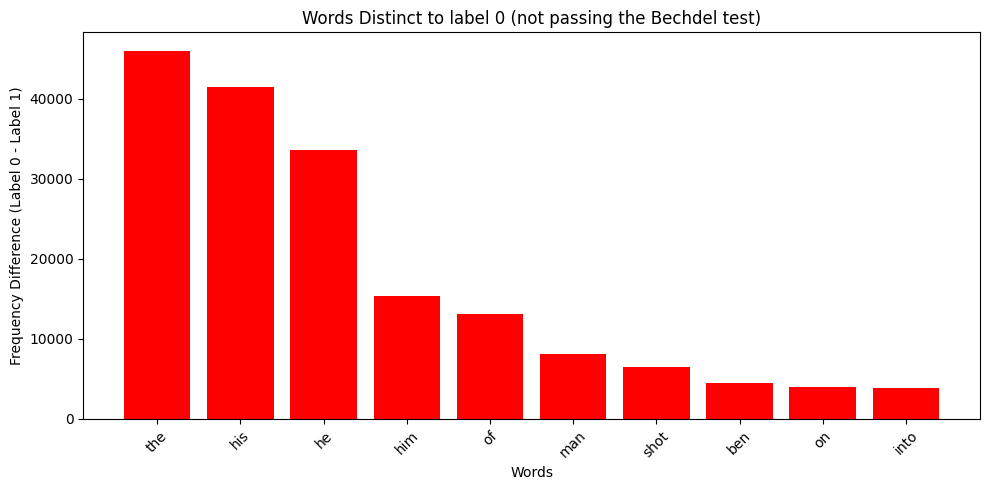

In [ ]:
# Find the top 10 words distinct to label 0
#top_indices_distinct_label_0 = np.argsort(filtered_frequency_diff)[:15]  # Largest negative differences
#distinct_words_label_0 = filtered_words[top_indices_distinct_label_0]
#distinct_frequencies_label_0 = filtered_frequency_diff[top_indices_distinct_label_0]

# Find the top 10 words distinct to label 1
top_indices_distinct_label_0 = np.argsort(filtered_frequency_diff)[:10]  # Largest positive differences
distinct_words_label_0 = filtered_words[top_indices_distinct_label_0]
distinct_frequencies_label_0 = filtered_frequency_diff[top_indices_distinct_label_0]

# Plot the distinct words for label 0
plt.figure(figsize=(10, 5))
plt.bar(distinct_words_label_0, -distinct_frequencies_label_0, color='red')  # Flip sign for better visualization
plt.title("Words Distinct to label 0 (not passing the Bechdel test)")
plt.xlabel("Words")
plt.ylabel("Frequency Difference (Label 0 - Label 1)")
plt.xticks(rotation=45)
plt.tight_layout()
#plt.savefig('../figures/BoW_words_label0.jpeg', format='jpeg', dpi=300) 

plt.show()


### BoW wordclouds

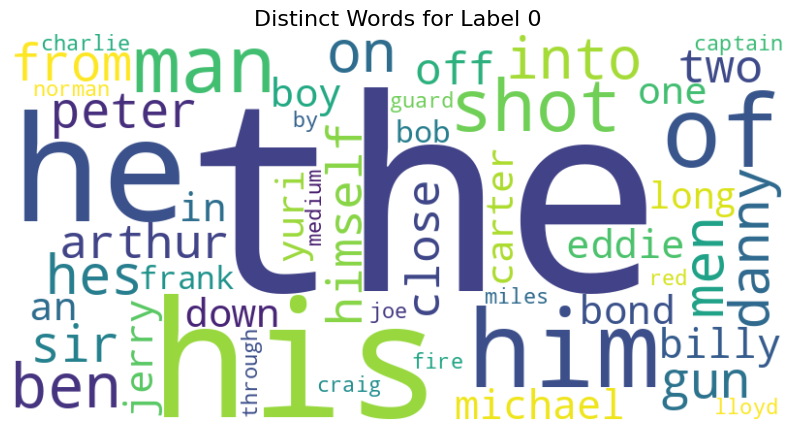

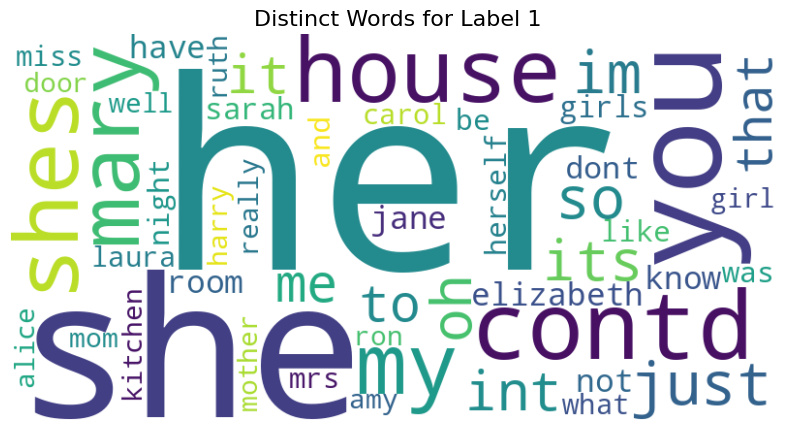

In [77]:
# Step 1: Define and preprocess variables
X = features_train.copy()  # Frequency matrix
labels = train_data['passed_bechdel']  # Binary label (0 or 1)

# Get the vocabulary mapping (word to column index)
vocabulary = vectorizer.vocabulary_ # vectorizer has already been initialized above
words = np.array(list(vocabulary.keys()))
word_indices = np.array(list(vocabulary.values()))

# Separate the word frequencies by label
X_label_0 = X[labels == 0].toarray().sum(axis=0)  # Word frequencies for label 0
X_label_1 = X[labels == 1].toarray().sum(axis=0)  # Word frequencies for label 1

# Calculate the difference in frequencies between label 1 and label 0
frequency_diff = X_label_1 - X_label_0

# Apply threshold filtering: Keep words with |frequency_diff| >= 5
threshold = 5
valid_indices = np.where(np.abs(frequency_diff) >= threshold)[0]
filtered_frequency_diff = frequency_diff[valid_indices]
filtered_words = words[word_indices.argsort()][valid_indices]

# Step 2: Find distinct words for each label
# Top 50 words distinct to label 1
top_indices_distinct_label_1 = np.argsort(filtered_frequency_diff)[-50:][::-1]  # Largest positive differences
distinct_words_label_1 = filtered_words[top_indices_distinct_label_1]
distinct_frequencies_label_1 = filtered_frequency_diff[top_indices_distinct_label_1]

# Top 50 words distinct to label 0
top_indices_distinct_label_0 = np.argsort(filtered_frequency_diff)[:50]  # Largest negative differences
distinct_words_label_0 = filtered_words[top_indices_distinct_label_0]
distinct_frequencies_label_0 = filtered_frequency_diff[top_indices_distinct_label_0]

path = "/work/classes/NLP_exam/figures/"

# Step 3: Create WordClouds for the distinct words
def generate_wordcloud_from_filtered(words, frequencies, title, file_name):

    word_freq = dict(zip(words, np.abs(frequencies)))
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
    
    # Plot the WordCloud with a title
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    
    # Save the plot 
    plt.savefig(path + file_name, bbox_inches='tight', dpi=300)
    plt.show()

# WordCloud for distinct words in label 0
generate_wordcloud_from_filtered(
    distinct_words_label_0, 
    distinct_frequencies_label_0, 
    "Distinct Words for Label 0",
    "wordcloud_label0.jpeg")

# WordCloud for distinct words in label 1
generate_wordcloud_from_filtered(
    distinct_words_label_1, 
    distinct_frequencies_label_1, 
    "Distinct Words for Label 1", 
    "wordcloud_label1.jpeg")

## TF-IDF

In [16]:
# initializing the new tf-idf vectorizer
vectorizer = TfidfVectorizer()

# fitting the training data
tf_idf_features_train = vectorizer.fit_transform(texts_train)

# transforming the validation and test data
tf_idf_features_val = vectorizer.transform(texts_val)
tf_idf_features_test = vectorizer.transform(texts_test)

# y values are the same as before

In [81]:
# sanity checking
print(tf_idf_features_train.shape)
vectorizer.vocabulary_

(1418, 339126)


{'alice': 24707,
 'by': 57022,
 'linda': 179313,
 'woolverton': 331083,
 'based': 41067,
 'on': 215199,
 'alices': 24717,
 'adventures': 21218,
 'in': 155352,
 'wonderland': 330728,
 'through': 299850,
 'the': 296163,
 'looking': 181877,
 'glass': 129786,
 'lewis': 177850,
 'carroll': 60852,
 '9908': 16306,
 'white': 327154,
 'shooting': 267457,
 'script': 260843,
 '102808': 1088,
 'blue': 48766,
 'revised': 249266,
 'pages': 221513,
 'fade': 111324,
 'ext': 109990,
 'london': 181445,
 '1855': 5003,
 'night': 207163,
 'warm': 322703,
 'light': 178648,
 'shines': 266736,
 'from': 122918,
 'study': 285868,
 'of': 212872,
 'gracious': 132809,
 'kingsley': 170421,
 'home': 147723,
 'man': 186254,
 'silhouetted': 269586,
 'window': 328945,
 'speaks': 277925,
 'with': 329731,
 'ardor': 31950,
 'int': 158081,
 'cont': 74527,
 'charles': 64479,
 'has': 140640,
 'just': 167187,
 'described': 87760,
 'his': 146397,
 'new': 206267,
 'venture': 317957,
 'to': 302274,
 'friends': 122609,
 'includin

Same procedure as with the BoW, testing the vectorizer as a classfier using different statistical models (logistic regression, random forest and SVC). I will try to implement them with the same hyperparameters as above. 

##### Update:
- __Logistic Regression__: The regularization parameter C was changed from 0.001 to 0.1, because was too constrained in that it ended up only predicting one of the two labels at every prediction.


### TF-IDF Logistic regression

In [17]:
#initializing logistic regression model again
tf_idf_log_reg = LogisticRegression(
    penalty = 'elasticnet', 
    C = 1,  ## CHANGED THIS FROM 0.001 to 1
    random_state=42, 
    solver = 'saga',
    max_iter = 10000,
    l1_ratio = 0.5
    ).fit(tf_idf_features_train, y_train) 

In [18]:
#checking that both labels are predicted
print("Unique predictions in validation set:", np.unique(tf_idf_log_reg.predict(tf_idf_features_val)))

Unique predictions in validation set: [0 1]


In [19]:
# evaluate model on validation dataset and save performance metrics
model = tf_idf_log_reg
model_name = 'tf_idf_log_reg'

for x, y, nsplit in zip([tf_idf_features_train, tf_idf_features_val, tf_idf_features_test],
                        [y_train, y_val, y_test],
                        ['train', 'val', 'test']):
    mean_accuracy_score = model.score(x, y) 
    preds = model.predict(x)
    f1 = f1_score(y, preds)
    class_report = classification_report(y, preds, output_dict = True)
    roc_auc = roc_auc_score(np.array(y), model.predict_proba(x)[:,1]) # takes the probabiltiy of label = 1 (passing the bechdel-test)
   # roc_curve_calc = roc_curve(np.array(y), clf_log_reg.predict_proba(x)[:,1])#, pos_label = 1)

    # Create a dictionary with metrics for the current split
    metrics = {
        'model': model_name,
        'split': nsplit,
        'mean_acc_score': round(mean_accuracy_score, 4),
        'f1_score': round(f1, 4),
        'cr_label0_precision': class_report['0']['precision'],
        'cr_label0_recall': class_report['0']['recall'],
        'cr_label0_f1_score': class_report['0']['f1-score'],
        'cr_label0_support': class_report['0']['support'],
        'cr_label1_precision': class_report['1']['precision'],
        'cr_label1_recall': class_report['1']['recall'],
        'cr_label1_f1_score': class_report['1']['f1-score'],
        'cr_label1_support': class_report['1']['support'],
        'roc_auc': roc_auc#,
        #'roc_curve': roc_curve_calc
    }
    
    # Convert the dictionary to a DataFrame and concatenate it with the main DataFrame
    performance_df = pd.concat([performance_df, pd.DataFrame([metrics])], ignore_index=True)

# Display the performance metrics
performance_df

,model,split,mean_acc_score,f1_score,cr_label0_precision,cr_label0_recall,cr_label0_f1_score,cr_label0_support,cr_label1_precision,cr_label1_recall,cr_label1_f1_score,cr_label1_support,roc_auc
0,BoW_log_reg,train,0.7934,0.7869,0.772487,0.828369,0.799452,705.0,0.817221,0.758766,0.786909,713.0,0.866432
1,BoW_log_reg,val,0.7797,0.7665,0.747475,0.840909,0.791444,88.0,0.820513,0.719101,0.766467,89.0,0.867339
2,BoW_log_reg,test,0.7022,0.6826,0.673267,0.772727,0.719577,88.0,0.740260,0.633333,0.682635,90.0,0.746338
3,BoW_rf,train,0.7786,0.7711,0.757576,0.815603,0.785519,705.0,0.802731,0.741935,0.771137,713.0,0.866319
4,BoW_rf,val,0.7627,0.7439,0.725490,0.840909,0.778947,88.0,0.813333,0.685393,0.743902,89.0,0.850613
5,BoW_rf,test,0.6798,0.6503,0.647619,0.772727,0.704663,88.0,0.726027,0.588889,0.650307,90.0,0.739899
6,BoW_svc,train,0.8096,0.7861,0.750288,0.924823,0.828463,705.0,0.903461,0.695652,0.786054,713.0,0.919259
7,BoW_svc,val,0.7571,0.7152,0.695652,0.909091,0.788177,88.0,0.870968,0.606742,0.715232,89.0,0.847612
8,BoW_svc,test,0.7135,0.6623,0.658120,0.875000,0.751220,88.0,0.819672,0.555556,0.662252,90.0,0.763510
9,tf_idf_log_reg,train,0.7701,0.7549,0.736579,0.836879,0.783533,705.0,0.813614,0.704067,0.754887,713.0,0.833858


In [ ]:
# save model performances
#performance_df.to_csv('/work/classes/NLP_exam/3_model_selection/output/performances_df.csv', index = False)
# reload if stopping mid-way
#performance_df = pd.read_csv('/work/classes/NLP_exam/3_model_selection/output/performances_df.csv')

### TF-IDF random forest

In [21]:
# tf-idf random forest
# initializing random forest with the hyperparameters from the randomized search 
tf_idf_forest = RandomForestClassifier(
    n_estimators = 100,
    min_samples_split = 2, 
    max_features = 0.3,
    max_depth = 20, 
    ccp_alpha = 0.01,
    random_state=42).fit(tf_idf_features_train, y_train)


In [23]:
#checking that both labels are predicted
print("Unique predictions in validation set:", np.unique(tf_idf_forest.predict(tf_idf_features_val)))

Unique predictions in validation set: [0 1]


In [22]:
# save / reload model
pkl.dump(tf_idf_forest, file=open(f'/work/classes/NLP_exam/3_model_selection/output/models/tf_idf_forest.pkl', 'wb')) # save the model
#tf_idf_forest = pkl.load(open('/work/classes/NLP_exam/3_model_selection/output/models/tf_idf_forest.pkl','rb'))

In [24]:
model = tf_idf_forest
model_name = 'tf_idf_rf'

for x, y, nsplit in zip([tf_idf_features_train, tf_idf_features_val, tf_idf_features_test],
                        [y_train, y_val, y_test],
                        ['train', 'val', 'test']):
    mean_accuracy_score = model.score(x, y) 
    preds = model.predict(x)
    f1 = f1_score(y, preds)
    class_report = classification_report(y, preds, output_dict = True)
    roc_auc = roc_auc_score(np.array(y), model.predict_proba(x)[:,1]) # takes the probabiltiy of label = 1 (passing the bechdel-test)
    
    # Create a dictionary with metrics for the current split
    metrics = {
        'model': model_name,
        'split': nsplit,
        'mean_acc_score': round(mean_accuracy_score, 4),
        'f1_score': round(f1, 4),
        'cr_label0_precision': class_report['0']['precision'],
        'cr_label0_recall': class_report['0']['recall'],
        'cr_label0_f1_score': class_report['0']['f1-score'],
        'cr_label0_support': class_report['0']['support'],
        'cr_label1_precision': class_report['1']['precision'],
        'cr_label1_recall': class_report['1']['recall'],
        'cr_label1_f1_score': class_report['1']['f1-score'],
        'cr_label1_support': class_report['1']['support'],
        'roc_auc': roc_auc#,
        #'roc_curve': roc_curve_calc
    }
    
    # Convert the dictionary to a DataFrame and concatenate it with the main DataFrame
    performance_df = pd.concat([performance_df, pd.DataFrame([metrics])], ignore_index=True)

# Display the performance metrics
performance_df

,model,split,mean_acc_score,f1_score,cr_label0_precision,cr_label0_recall,cr_label0_f1_score,cr_label0_support,cr_label1_precision,cr_label1_recall,cr_label1_f1_score,cr_label1_support,roc_auc
0,BoW_log_reg,train,0.7934,0.7869,0.772487,0.828369,0.799452,705.0,0.817221,0.758766,0.786909,713.0,0.866432
1,BoW_log_reg,val,0.7797,0.7665,0.747475,0.840909,0.791444,88.0,0.820513,0.719101,0.766467,89.0,0.867339
2,BoW_log_reg,test,0.7022,0.6826,0.673267,0.772727,0.719577,88.0,0.740260,0.633333,0.682635,90.0,0.746338
3,BoW_rf,train,0.7786,0.7711,0.757576,0.815603,0.785519,705.0,0.802731,0.741935,0.771137,713.0,0.866319
4,BoW_rf,val,0.7627,0.7439,0.725490,0.840909,0.778947,88.0,0.813333,0.685393,0.743902,89.0,0.850613
5,BoW_rf,test,0.6798,0.6503,0.647619,0.772727,0.704663,88.0,0.726027,0.588889,0.650307,90.0,0.739899
6,BoW_svc,train,0.8096,0.7861,0.750288,0.924823,0.828463,705.0,0.903461,0.695652,0.786054,713.0,0.919259
7,BoW_svc,val,0.7571,0.7152,0.695652,0.909091,0.788177,88.0,0.870968,0.606742,0.715232,89.0,0.847612
8,BoW_svc,test,0.7135,0.6623,0.658120,0.875000,0.751220,88.0,0.819672,0.555556,0.662252,90.0,0.763510
9,tf_idf_log_reg,train,0.7701,0.7549,0.736579,0.836879,0.783533,705.0,0.813614,0.704067,0.754887,713.0,0.833858


### TF-IDF SVC

In [ ]:
# support vector maching # max_iter=500
tf_idf_svc = SVC(C=0.5, kernel = 'rbf', probability=True, random_state = 42).fit(tf_idf_features_train, y_train)
# C = 1 and kernel = 'rbf' is the default hyperparameters of the SVC

In [31]:
#checking that both labels are predicted
print("Unique predictions in validation set:", np.unique(tf_idf_svc.predict(tf_idf_features_val)))

Unique predictions in validation set: [0 1]


In [ ]:
model = tf_idf_svc
model_name = 'tf_idf_svc'

for x, y, nsplit in zip([tf_idf_features_train, tf_idf_features_val, tf_idf_features_test], 
                        [y_train, y_val, y_test],
                        ['train', 'val', 'test']):
    mean_accuracy_score = model.score(x, y) 
    preds = model.predict(x)
    f1 = f1_score(y, preds)
    class_report = classification_report(y, preds, output_dict = True)

    # Get predicted probabilities for the positive class (class 1)
    y_pred_proba = model.predict_proba(x)[:, 1]  # Probabilities for class 1

    # Compute the ROC AUC score
    roc_auc = roc_auc_score(np.array(y), y_pred_proba)

    #roc_auc = roc_auc_score(np.array(y), clf_svm.predict_proba(x)[:,1]) # takes the probabiltiy of label = 1 (passing the bechdel-test)
   # roc_curve_calc = roc_curve(np.array(y), clf_log_reg.predict_proba(x)[:,1])#, pos_label = 1)

    # Create a dictionary with metrics for the current split
    metrics = {
        'model': model_name,
        'split': nsplit,
        'mean_acc_score': round(mean_accuracy_score, 4),
        'f1_score': round(f1, 4),
        'cr_label0_precision': class_report['0']['precision'],
        'cr_label0_recall': class_report['0']['recall'],
        'cr_label0_f1_score': class_report['0']['f1-score'],
        'cr_label0_support': class_report['0']['support'],
        'cr_label1_precision': class_report['1']['precision'],
        'cr_label1_recall': class_report['1']['recall'],
        'cr_label1_f1_score': class_report['1']['f1-score'],
        'cr_label1_support': class_report['1']['support'],
        'roc_auc': roc_auc#,
        #'roc_curve': roc_curve_calc
    }
    
    # Convert the dictionary to a DataFrame and concatenate it with the main DataFrame
    performance_df = pd.concat([performance_df, pd.DataFrame([metrics])], ignore_index=True)

# Display the performance metrics
performance_df

In [35]:
performance_df

,model,split,mean_acc_score,f1_score,cr_label0_precision,cr_label0_recall,cr_label0_f1_score,cr_label0_support,cr_label1_precision,cr_label1_recall,cr_label1_f1_score,cr_label1_support,roc_auc
0,BoW_log_reg,train,0.7934,0.7869,0.772487,0.828369,0.799452,705.0,0.817221,0.758766,0.786909,713.0,0.866432
1,BoW_log_reg,val,0.7797,0.7665,0.747475,0.840909,0.791444,88.0,0.820513,0.719101,0.766467,89.0,0.867339
2,BoW_log_reg,test,0.7022,0.6826,0.673267,0.772727,0.719577,88.0,0.740260,0.633333,0.682635,90.0,0.746338
3,BoW_rf,train,0.7786,0.7711,0.757576,0.815603,0.785519,705.0,0.802731,0.741935,0.771137,713.0,0.866319
4,BoW_rf,val,0.7627,0.7439,0.725490,0.840909,0.778947,88.0,0.813333,0.685393,0.743902,89.0,0.850613
5,BoW_rf,test,0.6798,0.6503,0.647619,0.772727,0.704663,88.0,0.726027,0.588889,0.650307,90.0,0.739899
6,BoW_svc,train,0.8096,0.7861,0.750288,0.924823,0.828463,705.0,0.903461,0.695652,0.786054,713.0,0.919259
7,BoW_svc,val,0.7571,0.7152,0.695652,0.909091,0.788177,88.0,0.870968,0.606742,0.715232,89.0,0.847612
8,BoW_svc,test,0.7135,0.6623,0.658120,0.875000,0.751220,88.0,0.819672,0.555556,0.662252,90.0,0.763510
9,tf_idf_log_reg,train,0.7701,0.7549,0.736579,0.836879,0.783533,705.0,0.813614,0.704067,0.754887,713.0,0.833858


In [ ]:
# save / reload model
#pkl.dump(tf_idf_svc, file=open(f'/work/classes/NLP_exam/3_model_selection/output/models/tf_idf_svc.pkl', 'wb')) # save the model
#tf_idf_svc = pkl.load(open('/work/classes/NLP_exam/3_model_selection/output/models/tf_idf_svc.pkl','rb'))

In [36]:
# save model performances
performance_df.to_csv('/work/classes/NLP_exam/3_model_selection/output/performances_df.csv', index = False)
# reload if stopping mid-way
#performance_df = pd.read_csv('/work/classes/NLP_exam/3_model_selection/output/performances_df.csv')

## Plotting performances of models

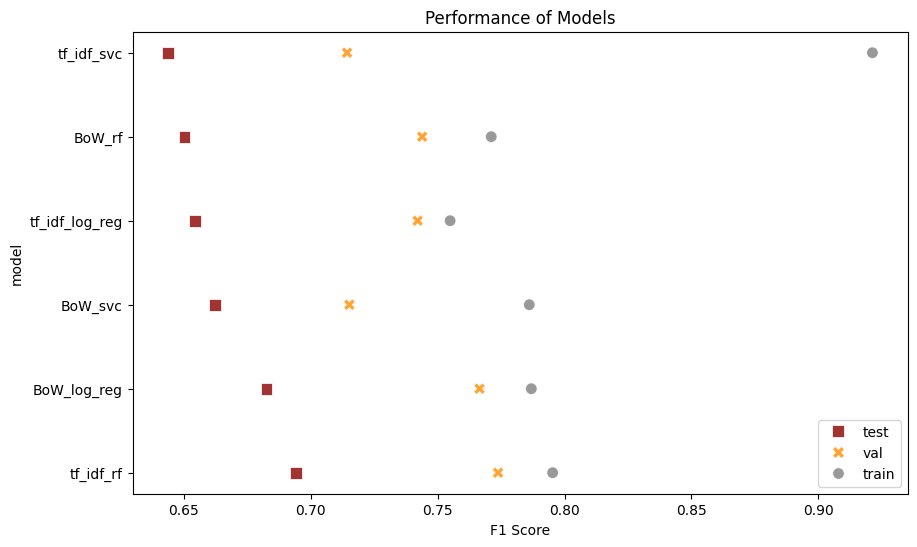

In [ ]:
# Specify the order of the legend and the icons
order = ['test', 'val', 'train']
markers = {'test': 's', 'val': 'X', 'train': 'o'}

# Sort the DataFrame by split and f1_score
performance_df['split_order'] = performance_df['split'].map({v: i for i, v in enumerate(order)})  # Map splits to numeric order
performance_df_sorted = performance_df.sort_values(by=['split_order', 'f1_score'], ascending=[True, True])  # Sort by split order and f1_score

# Plot
fig, ax = plt.subplots(figsize=(10, 6))  # Make wider to show all points
sns.scatterplot(data=performance_df_sorted, 
                y='model', 
                x='f1_score', 
                style='split',
                hue='split', 
                markers=markers,
                palette=['darkred', 'darkorange', 'grey'],
                hue_order=order, 
                style_order=order, 
                s=70,
                alpha=0.8)

# Customize plot
plt.title("Performance of Models")
plt.xlabel("F1 Score")
plt.legend(loc='lower right')  # Adjust legend position

# Remove temporary column used for sorting
performance_df.drop(columns='split_order', inplace=True)
#plt.savefig('../figures/model_performance.jpeg', format='jpeg', dpi=300) 
plt.show()
